<a href="https://colab.research.google.com/github/KavishkaGunathilaka/Doc-AI-Notebooks/blob/main/LiLT_XLM_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [ ]:
!pip install -q transformers
!sudo apt install tesseract-ocr-eng
!pip install  -q pytesseract
!pip install -q  datasets
!sudo apt-get install tesseract-ocr-sin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 k

In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd =  r'/usr/bin/tesseract'

In [ ]:
from datasets import load_dataset
dataset = load_dataset("nielsr/funsd")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# image = Image.open(dataset["test"][34]["image_path"])
# display(image)

# lilt-en-funsd

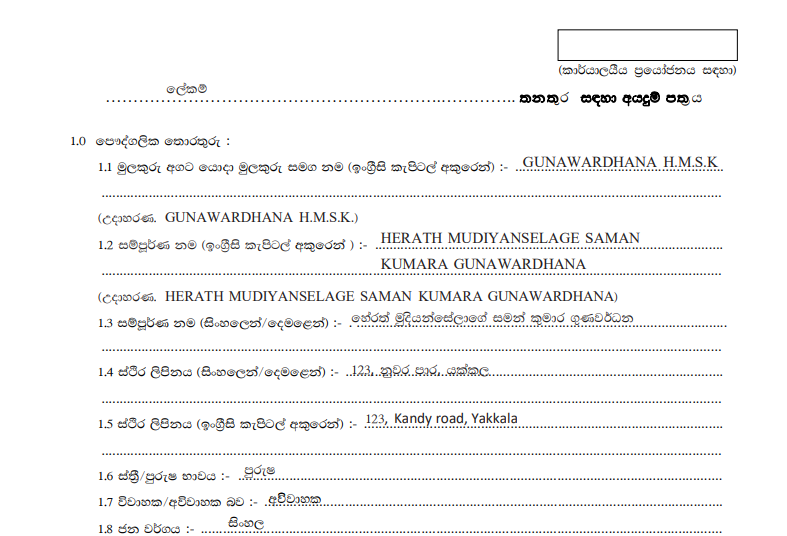

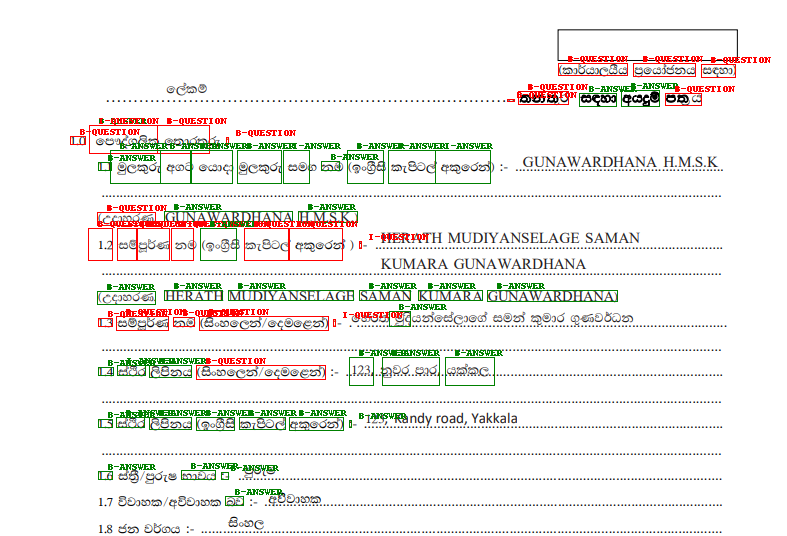

In [ ]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("philschmid/lilt-en-funsd")
processor = LayoutLMv3Processor.from_pretrained("philschmid/lilt-en-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels

# image = Image.open(dataset["test"][34]["image_path"]).convert('RGB')
image = Image.open('/content/Screenshot_cropped.png').convert('RGB')
display(image)
run_inference(image)


In [ ]:
model.config

LiltConfig {
  "_name_or_path": "philschmid/lilt-en-funsd",
  "architectures": [
    "LiltForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "channel_shrink_ratio": 4,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-HEADER",
    "2": "I-HEADER",
    "3": "B-QUESTION",
    "4": "I-QUESTION",
    "5": "B-ANSWER",
    "6": "I-ANSWER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-ANSWER": 5,
    "B-HEADER": 1,
    "B-QUESTION": 3,
    "I-ANSWER": 6,
    "I-HEADER": 2,
    "I-QUESTION": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 1024,
  "model_type": "lilt",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version

In [ ]:
image = Image.open(dataset["test"][34]["image_path"]).convert('RGB')
encoding = processor(image, return_tensors="pt")
print(encoding.keys())

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])


# lilt-xlm-roberta-base-finetuned-funsd-iob-original

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from PIL import Image, ImageDraw, ImageFont
import torch
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# image = Image.open(dataset["test"][34]["image_path"]).convert('RGB')
image = Image.open('/content/Screenshot_cropped.png').convert('RGB')

In [ ]:
!tesseract --list-langs

List of available languages (3):
eng
osd
sin


In [ ]:
# print(pytesseract.image_to_string(Image.open('/content/Screenshot 2023-08-04 210136.png').convert('RGB'), lang='eng+sin'))

In [ ]:
width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame', lang='eng+sin')

ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
# ocr_df[:20]

In [ ]:
len(ocr_df)

75

In [ ]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
# boxes

In [ ]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2".
      special_tokens_count = 2
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]

      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length

      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("nielsr/lilt-xlm-roberta-base")

In [ ]:
args = {
        'max_seq_length': 512,
}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

In [ ]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [ ]:
tokenizer.decode(input_ids)

"<s> (කාර්යාලයීය ප් රයෝජනය සඳහා).. තනතුර සඳහා අයදුම් පත ය 1.0 පෞද්ගලික තොරතුරු : 1.1 මුලකුරු අගට යොදා මුලකුරු සමග නම (ඉංග් රීසි කැපිටල් අකුරෙන් ) (egos. GUNAWARDHANA H.M.S.K.) 1.2 සම්පූර්ණ නම (ඉංග් රීසි කැපිටල් අකුරෙන් ) : (e966, HERATH MUDIYANSELAGE SAMAN KUMARA GUNAWARDHANA) 1.3 සම්පූර්ණ නම (සිංහලෙන් / දෙමළෙන් ) :: Bo 1.4 ස්ථිර ලිපිනය (සිංහලෙන් දෙමළෙන් ).423,..කුවර.පෘර..යුක්කල... 1.3 ස්ථිර ලිපිනය (ඉංග් රීසි කැපිටල් අකුරෙන් ) :: 1.6 ස්ත් රී 'පුරුෂ භාවය :- 1.7 විවාහක /අවිවාහක බව :- 1.8 ජන වර්ගය සි.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [ ]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

torch.Size([1, 512])

In [ ]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

torch.Size([1, 512])

In [ ]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

torch.Size([1, 512])

In [ ]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

torch.Size([1, 512, 4])

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("pierreguillou/lilt-xlm-roberta-base-finetuned-funsd-iob-original")

In [ ]:
# model

In [ ]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask)
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[ 0.1006, -0.8476, -0.6148,  ...,  0.5493, -0.2687, -0.4111],
         [ 9.4153, -1.0806, -2.3538,  ..., -0.6230, -1.2101, -2.6039],
         [ 9.4194, -1.0598, -1.9999,  ..., -0.6519, -2.0378, -2.2341],
         ...,
         [-0.1173, -1.0224, -0.6471,  ...,  0.9614, -0.3322, -0.2797],
         [-0.1173, -1.0224, -0.6471,  ...,  0.9614, -0.3322, -0.2797],
         [-0.1173, -1.0224, -0.6471,  ...,  0.9614, -0.3322, -0.2797]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits.shape

torch.Size([1, 512, 7])

In [ ]:
outputs.logits.argmax(-1)

tensor([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 1, 2, 2, 2,
         3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4

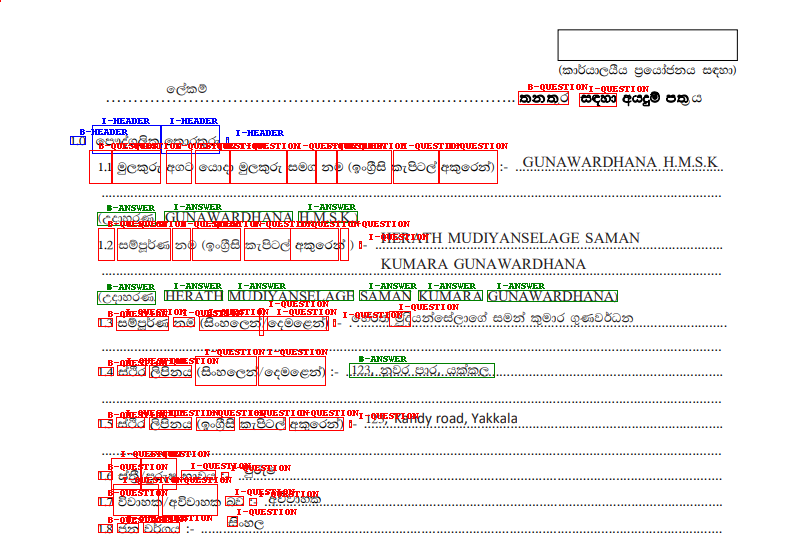

In [ ]:
label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}

# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def draw_boxes(image, boxes, predictions):
  width, height = image.size
  normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

  # draw predictions over the image
  draw = ImageDraw.Draw(image)
  font = ImageFont.load_default()
  for prediction, box in zip(predictions, normalizes_boxes):
      if prediction == "O":
          continue
      draw.rectangle(box, outline="black")
      draw.rectangle(box, outline=label2color[prediction])
      draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
  return image

predictions = outputs.logits.argmax(-1).squeeze().tolist()
# get labels
labels = [model.config.id2label[prediction] for prediction in predictions]
display(draw_boxes(image, bbox[0], labels))